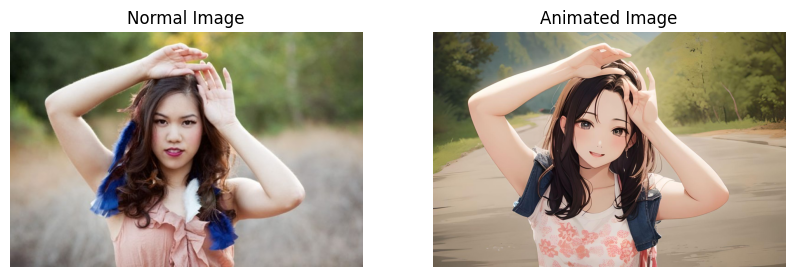

100%|██████████| 48/48 [00:02<00:00, 19.38it/s]



Shape of preprocessed Input: (48, 256, 256)
Shape of preprocessed Output: (48, 256, 256, 2)


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image

import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio

# Specify the path to your folder containing mixed images
folder_path = 'nor'

# Create Input and Output variables
Input = []
Output = []

# Iterate through files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        file_name, file_extension = os.path.splitext(filename)
        animated_filename = f"{file_name}_ai{file_extension}"

        # Check if animated counterpart exists
        if animated_filename in os.listdir(folder_path):
            Input.append(os.path.join(folder_path, filename))
            Output.append(os.path.join(folder_path, animated_filename))

# Display the first normal and its animated counterpart using Matplotlib
if Input and Output:
    normal_image_path = Input[3]
    animated_image_path = Output[3]

    # Load images using Matplotlib
    normal_image = mpimg.imread(normal_image_path)
    animated_image = mpimg.imread(animated_image_path)

    # Display images side by side
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(normal_image)
    plt.title('Normal Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(animated_image)
    plt.title('Animated Image')
    plt.axis('off')

    plt.show()

# Convert images to LAB color space and normalize
def preprocess_image(image_path):
    image = load_img(image_path, target_size=(256, 256), color_mode='rgb')
    image = img_to_array(image) / 255.0
    lab_image = rgb2lab(image)
    return lab_image

# Preprocess Input and Output
Input_preprocessed = np.array([preprocess_image(image_path)[:, :, 0] for image_path in tqdm(Input)])
Output_preprocessed = np.array([preprocess_image(image_path)[:, :, 1:] / 128 for image_path in tqdm(Output)])

# Print shapes of preprocessed data
print("\nShape of preprocessed Input:", Input_preprocessed.shape)
print("Shape of preprocessed Output:", Output_preprocessed.shape)


In [ ]:
Input_preprocessed=np.expand_dims(Input_preprocessed,axis=-1)
print('Input shape is ' , Input_preprocessed.shape)
print('Output shape is ' , Output_preprocessed.shape)


Input shape is  (48, 256, 256, 1)
Output shape is  (48, 256, 256, 2)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Input_preprocessed,Output_preprocessed, test_size=0.2, random_state=44, shuffle =True)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (38, 256, 256, 1)
X_test shape is  (10, 256, 256, 1)
y_train shape is  (38, 256, 256, 2)
y_test shape is  (10, 256, 256, 2)


In [ ]:
# Input layer with shape (200, 200, 1)
input_ = keras.layers.Input(shape=(256,256,1))
# Encoder
x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu',strides=2)(input_)
x = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu',strides=2)(x)
x = keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu',strides=2)(x)
x = keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
encoder = keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)

# Decoder
x = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(encoder)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x)
# Adjust the output layer for an RGB image (2 channels)
x = keras.layers.Conv2D(2, (3, 3), padding='same', activation=keras.layers.LeakyReLU(alpha=.5))(x)
decoder = keras.layers.UpSampling2D((2, 2))(x)
# Autoencoder model
autoencoder = keras.models.Model(inputs=input_, outputs=decoder)
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 512)       118016

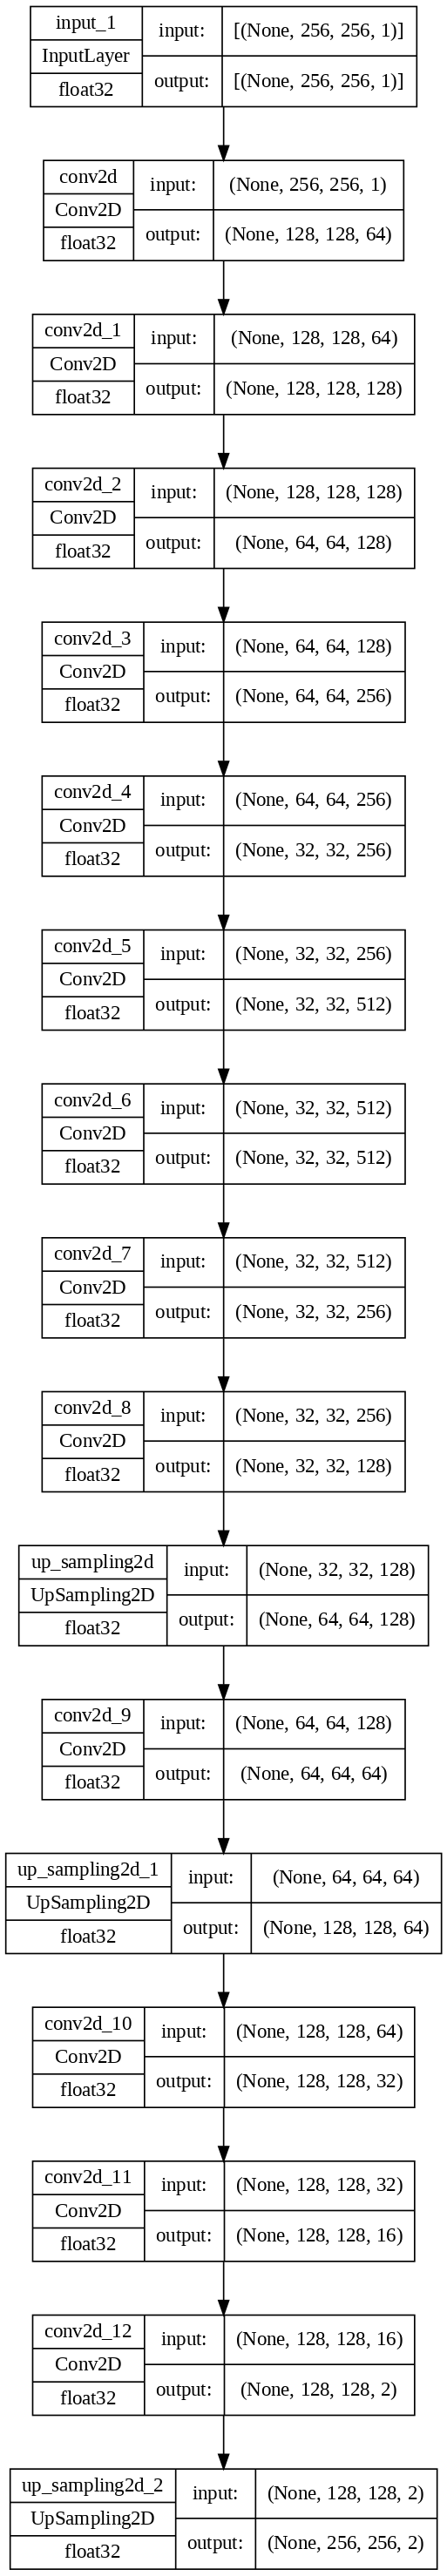

In [ ]:
tf.keras.utils.plot_model(autoencoder, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [ ]:
checkpoint_cb =ModelCheckpoint("autoencoder.h5",save_best_only=True)
autoencoder.compile(optimizer ='adam', loss='mse')
hist=autoencoder.fit(X_train,y_train,epochs=10,validation_split=.1,callbacks=[checkpoint_cb])

Epoch 1/10
2/2 [==============================] - 51s 4s/step - loss: 0.0866 - val_loss: 0.0083
Epoch 2/10
2/2 [==============================] - 51s 5s/step - loss: 0.0164 - val_loss: 0.0122
Epoch 3/10
2/2 [==============================] - 46s 4s/step - loss: 0.0205 - val_loss: 0.0124
Epoch 4/10
2/2 [==============================] - 45s 4s/step - loss: 0.0209 - val_loss: 0.0104
Epoch 5/10
2/2 [==============================] - 46s 4s/step - loss: 0.0181 - val_loss: 0.0093
Epoch 6/10
2/2 [==============================] - 46s 4s/step - loss: 0.0187 - val_loss: 0.0064
Epoch 7/10
2/2 [==============================] - 45s 4s/step - loss: 0.0137 - val_loss: 0.0057
Epoch 8/10
2/2 [==============================] - 46s 4s/step - loss: 0.0132 - val_loss: 0.0098
Epoch 9/10
2/2 [==============================] - 44s 4s/step - loss: 0.0213 - val_loss: 0.0064
Epoch 10/10
2/2 [==============================] - 44s 4s/step - loss: 0.0138 - val_loss: 0.0083


In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,val_loss
0,0.086622,0.008290
1,0.016370,0.012174
2,0.020535,0.012448
3,0.020855,0.010431
4,0.018107,0.009286
5,0.018722,0.006416
6,0.013696,0.005654
7,0.013157,0.009791
8,0.021257,0.006403
9,0.013815,0.008341


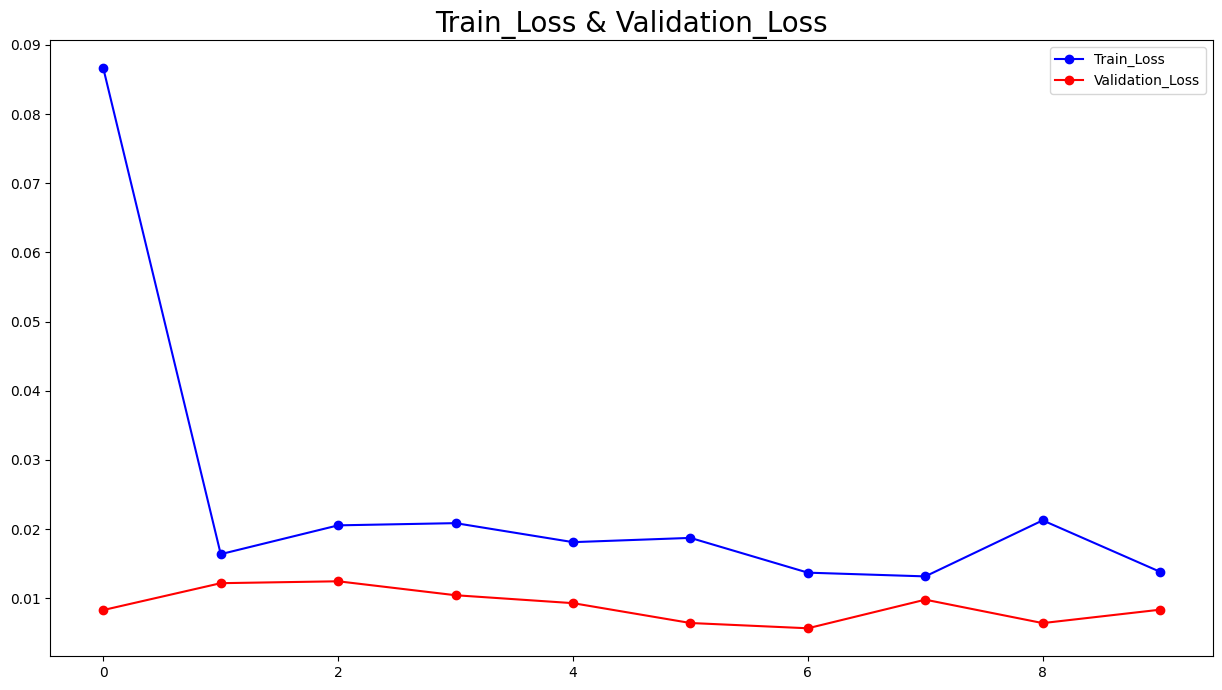

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(hist_['loss'],'b-o',label='Train_Loss')
plt.plot(hist_['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.show()

In [ ]:
autoencoder.evaluate(X_test,y_test)

1/1 [==============================] - 3s 3s/step - loss: 0.0167


0.01668449118733406

In [ ]:
predictions = autoencoder.predict(X_test)
predictions.shape

1/1 [==============================] - 4s 4s/step


(10, 256, 256, 2)

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

def generate_animated_image(model, normal_image_path):
    # Load and preprocess the normal image
    normal_image = load_img(normal_image_path, target_size=(256, 256), color_mode='grayscale')
    normal_image = img_to_array(normal_image) / 255.0
    normal_image = np.expand_dims(normal_image, axis=0)  # Add batch dimension

    # Use the autoencoder model to generate animated image
    animated_image = autoencoder.predict(normal_image)

    # Post-process the generated animated image
    animated_image = animated_image.squeeze()
    animated_image = animated_image * 128  # Rescale values to original range

    return animated_image

# Example usage:
normal_image_path = 'image.jpg'
generated_animated_image = generate_animated_image(autoencoder, normal_image_path)


1/1 [==============================] - 0s 336ms/step


In [ ]:
psnr_values=[abs(peak_signal_noise_ratio(color,pred,data_range=color.max()-pred.min()))
             for color,pred in zip(y_test,predictions)]
print('Average PSNR =',np.mean(psnr_values))